In [ ]:

!pip install transformers accelerate peft datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModel,
    get_linear_schedule_with_warmup,
)
from peft import get_peft_model, LoraConfig, TaskType
from torch.cuda.amp import autocast, GradScaler
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

In [ ]:
# 1) Prepare your EmoBank data as before
emobank = pd.read_csv("emobank.csv")[['text','V','A']].dropna().reset_index(drop=True)
# len buckets → wide features
emobank['len_bucket'] = pd.cut(
    emobank['text'].str.len(),
    bins=[0,50,100,150,200,300,500], labels=False
)
wide_feats = torch.tensor(
    pd.get_dummies(emobank['len_bucket']).values,
    dtype=torch.float32
)
raw_targets = emobank[['V','A']].values
target_scaler = StandardScaler().fit(raw_targets)
y_scaled = target_scaler.transform(raw_targets)
y_scaled = torch.tensor(y_scaled, dtype=torch.float32)

# 2) Tokenizer + Model backbone
MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
bert = AutoModel.from_pretrained(MODEL_NAME)

# 3) Attach LoRA adapters
lora_config = LoraConfig(
    task_type=TaskType.FEATURE_EXTRACTION,  # regression head on top
    inference_mode=False,
    r=8,
    lora_alpha=16,
    target_modules=["query", "value"],  # these module names work for MiniLM
    lora_dropout=0.1
)
model = get_peft_model(bert, lora_config)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

In [ ]:
# 4) Freeze all non-LoRA parameters
for name, param in model.named_parameters():
    if "lora_" not in name:
        param.requires_grad = False

# 5) Define your VA head
class VAHead(torch.nn.Module):
    def __init__(self, wide_dim, hidden_dim=128):
        super().__init__()
        self.wide_mlp = torch.nn.Sequential(
            torch.nn.Linear(wide_dim, 32), torch.nn.ReLU(), torch.nn.Dropout(0.1)
        )
        self.text_mlp = torch.nn.Sequential(
            torch.nn.Linear(model.config.hidden_size, hidden_dim),
            torch.nn.ReLU(), torch.nn.Dropout(0.1)
        )
        self.out = torch.nn.Linear(hidden_dim + 32, 2)

    def forward(self, text_repr, wide):
        w = self.wide_mlp(wide)
        t = self.text_mlp(text_repr)
        return self.out(torch.cat([t, w], dim=1))

head = VAHead(wide_feats.shape[1]).to("cuda")

In [ ]:
# 6) Build a Dataset & DataLoader
class EmobankDataset(Dataset):
    def __init__(self, texts, wides, targets, tokenizer):
        self.texts = texts
        self.wides = wides
        self.targets = targets
        self.tokenizer = tokenizer

    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            truncation=True, padding="max_length", max_length=128,
            return_tensors="pt"
        )
        return {
            "input_ids": enc.input_ids.squeeze(0),
            "attention_mask": enc.attention_mask.squeeze(0),
            "wide": self.wides[idx],
            "target": self.targets[idx]
        }


In [ ]:
# split train/val
from sklearn.model_selection import train_test_split
idx_tr, idx_val = train_test_split(
    np.arange(len(emobank)), test_size=0.2, random_state=42
)
ds_tr = EmobankDataset(
    emobank.loc[idx_tr, 'text'].tolist(),
    wide_feats[idx_tr],
    y_scaled[idx_tr],
    tokenizer
)
ds_val = EmobankDataset(
    emobank.loc[idx_val, 'text'].tolist(),
    wide_feats[idx_val],
    y_scaled[idx_val],
    tokenizer
)

train_loader = DataLoader(ds_tr, batch_size=16, shuffle=True)
val_loader   = DataLoader(ds_val, batch_size=32)

In [ ]:
# 7) Optimizer, scheduler, AMP scaler
from torch.optim import Adam
optimizer = Adam(
    list(model.parameters()) + list(head.parameters()),
    lr=3e-4,
    weight_decay=1e-5
)
total_steps = len(train_loader) * 5  # e.g. 5 epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=total_steps//10, num_training_steps=total_steps
)
scaler = GradScaler()

<ipython-input-7-6a71e7737c39>:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [ ]:
# 8) Training loop
device = "cuda"
model.to(device)
head.to(device)
loss_fn = torch.nn.SmoothL1Loss()

for epoch in range(1, 6):
    model.train(); head.train()
    train_loss = 0.0
    for step, batch in enumerate(train_loader, 1):
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        mask      = batch["attention_mask"].to(device)
        wide      = batch["wide"].to(device)
        target    = batch["target"].to(device)

        with autocast():
            # 8a) get [CLS] representation
            outputs = model(input_ids=input_ids, attention_mask=mask)
            cls_repr = outputs.last_hidden_state[:,0]  # batch x hidden_size
            preds = head(cls_repr, wide)
            loss = loss_fn(preds, target)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        train_loss += loss.item()
    avg_tr = train_loss/len(train_loader)

    # 8b) Validation
    model.eval(); head.eval()
    val_loss, all_preds, all_trues = 0, [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            mask      = batch["attention_mask"].to(device)
            wide      = batch["wide"].to(device)
            target    = batch["target"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=mask)
            cls_repr = outputs.last_hidden_state[:,0]
            preds = head(cls_repr, wide)
            val_loss += loss_fn(preds, target).item()
            all_preds.append(preds.cpu().numpy())
            all_trues.append(target.cpu().numpy())

    avg_val = val_loss/len(val_loader)
    preds_np = np.vstack(all_preds); trues_np = np.vstack(all_trues)
    from sklearn.metrics import r2_score
    val_r2 = r2_score(trues_np, preds_np)

    print(f"Epoch {epoch}: Train Loss={avg_tr:.3f}, Val Loss={avg_val:.3f}, Val R²={val_r2:.3f}")

<ipython-input-8-8b0a16f70a29>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1: Train Loss=0.337, Val Loss=0.272, Val R²=0.370


<ipython-input-8-8b0a16f70a29>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 2: Train Loss=0.266, Val Loss=0.260, Val R²=0.412


<ipython-input-8-8b0a16f70a29>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 3: Train Loss=0.252, Val Loss=0.254, Val R²=0.427


<ipython-input-8-8b0a16f70a29>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 4: Train Loss=0.244, Val Loss=0.253, Val R²=0.428


<ipython-input-8-8b0a16f70a29>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 5: Train Loss=0.239, Val Loss=0.254, Val R²=0.427


In [ ]:

profiles = pd.read_csv(
    "usersha1-profile.tsv", sep="\t",
    names=["user","gender","age","country","signup"]
)
# bucket age
profiles["age_bin"] = pd.cut(
    profiles["age"].fillna(profiles["age"].median()),
    bins=[0,18,25,35,50,100],
    labels=["<18","18-25","25-35","35-50","50+"]
)

plays = pd.read_csv(
    "usersha1-artmbid-artname-plays.tsv", sep="\t",
    names=["user","artist_id","artist_name","plays"]
)
# each user's top artist
top_artist = (
    plays.groupby(["user","artist_name"])["plays"]
         .sum()
         .reset_index()
         .sort_values(["user","plays"], ascending=[True,False])
         .groupby("user")
         .first()["artist_name"]
)
# total plays → listen‐freq bin
total_plays = plays.groupby("user")["plays"].sum().rename("total_plays")
freq_bin = pd.cut(
    total_plays.fillna(0),
    bins=[-1,50,200,1000,1e9],
    labels=["low","medium","high","super"]
).rename("listen_freq")

logs = (
    profiles.set_index("user")
            .join(top_artist.rename("top_artist"), how="inner")
            .join(freq_bin, how="inner")
            .reset_index()
)
# Now logs has: user, gender, age, signup, age_bin, top_artist, listen_freq


In [ ]:

songs = pd.read_csv("spotify_millsongdata.csv")  # ensure it has: 'artist','song','text'

# 10a) bucket lyric length with same bins as EmoBank
bins = [0,50,100,150,200,300,500]
wide_dim = wide_feats.shape[1]  # from your Emobank one‐hot
song_buckets = pd.cut(
    songs["text"].str.len(),
    bins=bins,
    labels=False
).fillna(0).astype(int)

# 10b) one‐hot encode into a tensor
song_wide = torch.nn.functional.one_hot(
    torch.tensor(song_buckets.values),
    num_classes=wide_dim
).float().to(device)

# 10c) batch‐wise VA prediction
def predict_va(texts, wide_tensor, batch_size=16):
    model.eval(); head.eval()
    all_va = []
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i : i+batch_size]
            enc = tokenizer(
                batch_texts,
                truncation=True, padding=True, max_length=128,
                return_tensors="pt"
            ).to(device)
            cls_repr = model(
                input_ids=enc.input_ids,
                attention_mask=enc.attention_mask
            ).last_hidden_state[:,0]
            preds_scaled = head(cls_repr, wide_tensor[i : i+batch_size])
            va = target_scaler.inverse_transform(preds_scaled.cpu().numpy())
            all_va.append(va)
    return np.vstack(all_va)

song_va = predict_va(songs["text"].tolist(), song_wide, batch_size=16)
songs["V_pred"], songs["A_pred"] = song_va[:,0], song_va[:,1]



In [ ]:

import numpy as np

def recommend(query: str, user_id: str, top_k: int = 10):
    # 11a) predict query VA
    enc = tokenizer(
        query, truncation=True, padding=True, max_length=128, return_tensors="pt"
    ).to(device)
    cls_q = model(
        input_ids=enc.input_ids,
        attention_mask=enc.attention_mask
    ).last_hidden_state[:,0]
    # wide for query length
    q_bucket = int(pd.cut([len(query)], bins=bins, labels=False)[0])
    q_wide = torch.nn.functional.one_hot(
        torch.tensor([q_bucket]), num_classes=wide_dim
    ).float().to(device)
    with torch.no_grad():
        scaled = head(cls_q, q_wide).cpu().numpy().squeeze()
    q_va = target_scaler.inverse_transform(scaled.reshape(1,2)).squeeze()

    # 11b) filter by user’s top artist
    user_row = logs[logs["user"] == user_id].iloc[0]
    pref_artist = user_row["top_artist"]
    cand = songs[songs["artist"] == pref_artist].copy()
    if cand.empty:
        cand = songs.copy()

    # 11c) rank by Euclidean distance in VA space
    dists = np.linalg.norm(
        cand[["V_pred","A_pred"]].values - q_va, axis=1
    )
    idxs = np.argsort(dists)[:top_k]
    return cand.iloc[idxs][["artist","song","V_pred","A_pred"]]




In [ ]:
import numpy as np
import pandas as pd
import torch


# 1) BUILD EMOTION BUCKETS
va_vals = songs["V_pred"].values
# 5 equal-width bins from min→max
va_bins = np.linspace(va_vals.min(), va_vals.max(), num=6)
# discretize both songs and plays later
songs["va_bucket"] = pd.cut(vs:=songs["V_pred"], bins=va_bins, labels=False).fillna(0).astype(int)

# 2) LOAD PLAY COUNTS AND MERGE VA
plays = pd.read_csv(
    "usersha1-artmbid-artname-plays.tsv", sep="\t",
    names=["user","artist_id","artist","plays"]
)
# join each play record to its artist’s predicted VA
plays_song = plays.merge(
    songs[["artist","va_bucket"]],
    on="artist", how="inner"
)

# 3) AGGREGATE CROSS-PRODUCT PREFS
#    user × emotion
user_emotion_pref = plays_song.groupby(
    ["user","va_bucket"]
)["plays"].sum().to_dict()

#    emotion × genre (artist)
emotion_genre_pref = plays_song.groupby(
    ["va_bucket","artist"]
)["plays"].sum().to_dict()

In [ ]:


def recommend(query: str, user_id: str, top_k: int = 10):
    # (a) predict query VA & bucket
    # enc   = tokenizer(query, truncation=True, padding=True, max_length=128, return_tensors="pt").to(device)
    # cls_q = model(input_ids=enc.input_ids, attention_mask=enc.attention_mask).last_hidden_state[:,0]
    # q_scaled = head(cls_q, torch.tensor([[0]], dtype=torch.float32, device=device)).cpu().numpy().squeeze()
    # q_va = target_scaler.inverse_transform(q_scaled.reshape(1,2)).squeeze()
    # q_bucket = int(pd.cut([q_va[0]], bins=va_bins, labels=False)[0])
    # (a) predict query VA & bucket
    enc = tokenizer(query, truncation=True, padding=True, max_length=128, return_tensors="pt").to(device)
    cls_q = model(input_ids=enc.input_ids, attention_mask=enc.attention_mask).last_hidden_state[:, 0]

    q_len = len(query)
    q_bucket = int(pd.cut([q_len], bins=bins, labels=False)[0])
    q_wide = torch.nn.functional.one_hot(
        torch.tensor([q_bucket]), num_classes=wide_feats.shape[1]
    ).float().to(device)

    with torch.no_grad():
        q_scaled = head(cls_q, q_wide).cpu().numpy().squeeze()

    q_va = target_scaler.inverse_transform(q_scaled.reshape(1, 2)).squeeze()
    q_bucket = int(pd.cut([q_va[0]], bins=va_bins, labels=False)[0])  # re-bucket using predicted V


    # (b) get user×emotion memory
    mem_ue = user_emotion_pref.get((user_id, q_bucket), 0)

    # (c) filter candidate songs (by top-artist or all)
    user_row = logs[logs["user"]==user_id].iloc[0]
    cand = songs[songs["artist"]==user_row["top_artist"]]
    if cand.empty: cand = songs

    # (d) compute distance in VA
    dists = np.linalg.norm(cand[["V_pred","A_pred"]].values - q_va, axis=1)

    # (e) emotion×genre memory per candidate
    mem_eg = np.array([
        emotion_genre_pref.get((q_bucket, art), 0)
        for art in cand["artist"].values
    ], dtype=float)

    # (f) normalize mem_eg to zero-mean unit-std
    if mem_eg.std()>0:
        mem_eg = (mem_eg - mem_eg.mean()) / mem_eg.std()

    # (g) final scoring: negative distance + memorization
    scores = -dists + (mem_ue + mem_eg)

    # (h) pick top_k highest scores
    idxs = np.argsort(scores)[-top_k:][::-1]
    return cand.iloc[idxs][["artist","song","V_pred","A_pred"]]

if __name__=="__main__":
    u = logs["user"].iloc[0]
    print(recommend("crying a lot and panting", u, top_k=5).to_string(index=False))


       artist                                   song   V_pred   A_pred
    Zebrahead                                Brixton 2.291560 3.417861
Yolanda Adams                  Praise Your Holy Name 2.272602 3.415883
  The Monkees                           Admiral Mike 2.285190 3.410002
     Nazareth                                 Busted 2.273271 3.426336
 Freddie King It's Too Bad Things Are Going So Tough 2.273442 3.410935


In [ ]:

if __name__ == "__main__":
    some_user = logs["user"].iloc[0]
    recs = recommend("watching the sunset having a calm moment with friends", some_user, top_k=5)
    print(recs.to_string(index=False))

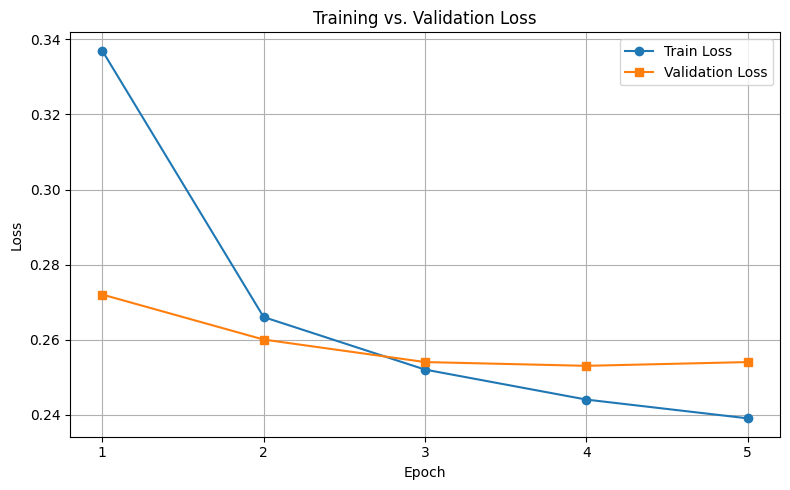

In [ ]:
import matplotlib.pyplot as plt

# Example lists – replace these with your recorded values per epoch
epochs       = list(range(1, 6))                   # e.g. [1, 2, 3, 4, 5]
train_losses = [0.337, 0.266, 0.252, 0.244, 0.239]  # your avg train losses
val_losses   = [0.272, 0.260, 0.254, 0.253, 0.254]  # your avg val losses

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, marker='o', label='Train Loss')
plt.plot(epochs, val_losses,   marker='s', label='Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
